# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

idx = np.arange(len(y))
idx_train, idx_test = train_test_split(
    idx, test_size=0.25, random_state=0, stratify=y
)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [3]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.

clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

clf_full.fit(Xf_train, yf_train)
clf_reduced.fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [4]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full, zero_division=0)
rec_full = recall_score(yf_test, ypred_full)

acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced, zero_division=0)
rec_reduced = recall_score(yr_test, ypred_reduced)

print("Full model (cape, pwat, shear):")
print(f"  Accuracy:  {acc_full:.3f}")
print(f"  Precision: {prec_full:.3f}")
print(f"  Recall:    {rec_full:.3f}")

print("\nReduced model (cape only):")
print(f"  Accuracy:  {acc_reduced:.3f}")
print(f"  Precision: {prec_reduced:.3f}")
print(f"  Recall:    {rec_reduced:.3f}")
# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5

Full model (cape, pwat, shear):
  Accuracy:  0.723
  Precision: 0.733
  Recall:    0.678

Reduced model (cape only):
  Accuracy:  0.717
  Precision: 0.736
  Recall:    0.651


## 4) Plot ROC and Precision–Recall Curves

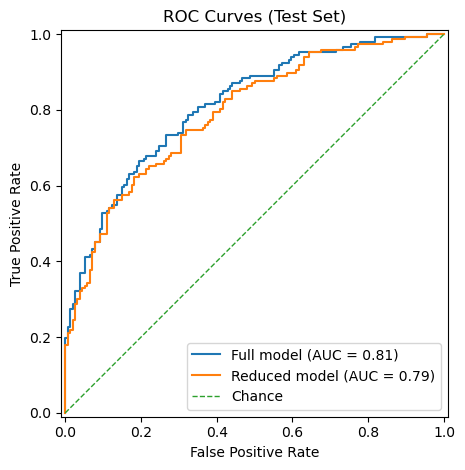

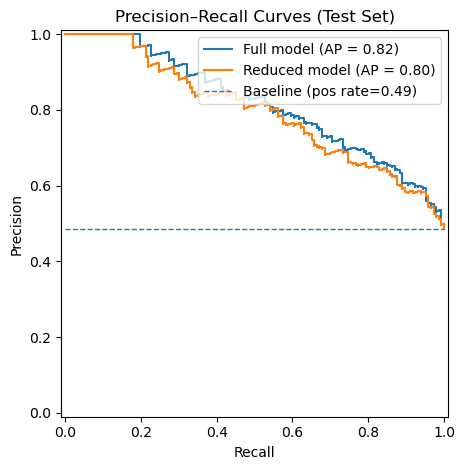

In [5]:
# TODO: Plot ROC and PR curves for both models on shared axes
# --- ROC (shared axes) ---
fig_roc, ax_roc = plt.subplots()
RocCurveDisplay.from_predictions(yf_test, yprob_full, name="Full model", ax=ax_roc)
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, name="Reduced model", ax=ax_roc)
ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Chance")
ax_roc.set_title("ROC Curves (Test Set)")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc="lower right")
fig_roc.tight_layout()

# --- Precision–Recall (shared axes) ---
fig_pr, ax_pr = plt.subplots()
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, name="Full model", ax=ax_pr)
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, name="Reduced model", ax=ax_pr)
# Baseline (positive rate in test set)
pos_rate = np.mean(yf_test)
ax_pr.hlines(pos_rate, 0, 1, linestyles="--", linewidth=1, label=f"Baseline (pos rate={pos_rate:.2f})")
ax_pr.set_title("Precision–Recall Curves (Test Set)")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.legend(loc="upper right")
fig_pr.tight_layout()

plt.show()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

#### <font color="DeepSkyBlue">Step 5 Answer:
1. 
ROC–AUC: Full = 0.81 > Reduced = 0.79
PR–AUC: Full = 0.82 > Reduced = 0.80

Including PWAT (precipitable water) and shear provides a small but consistent improvement in both the ranking ability (ROC–AUC) and precision–recall performance.
That means PWAT adds useful predictive information about whether an event occurs, as it helps the model better separate event vs. non-event cases beyond what CAPE alone can explain.

2. 
The full model slightly improves recall (0.678 > 0.651), meaning it catches more true events. The reduced model has almost identical precision (0.736 vs 0.733), so false alarms are about the same. Accuracy is nearly unchanged (difference ≈ 0.006).

To maximize event detection (recall): choose the full model, since it finds more events correctly. To minimize false alarms (precision): either model performs similarly, but if you had to pick, the reduced model has a very slight edge in precision.

PWAT adds modest predictive value. The full model is slightly better balanced overall and the better choice if detecting every possible event matters more than a few extra false alarms.</font>